In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.notebook import tqdm
import yfinance as yf
import alphalens as al

from prices import read_stock_prices
from plotter import plot

%load_ext autoreload
%autoreload 2

In [2]:
vader_df = pd.concat([pd.read_csv('sentiments/stocks_vader_mean_sentiment.csv'), 
                     pd.read_csv('sentiments/memestocks_vader_mean_sentiment.csv')])
vader_df

,Date,Stock,Sentiment
0,2021-01-01,AAPL,0.212245
1,2021-01-01,PLTR,0.230110
2,2021-01-01,TSLA,0.206411
3,2021-01-02,AAPL,0.180537
4,2021-01-02,PLTR,0.153601
...,...,...,...
355,2021-04-29,GME,0.154687
356,2021-04-29,NOK,0.234900
357,2021-04-30,AMC,0.169916
358,2021-04-30,GME,0.132105


In [3]:
roberta_df = pd.read_csv("sentiments/roberta-sentiment.csv", index_col=0)
roberta_df

,Date,Stock,Sentiment
0,2021-01-01,AAPL,0.335990
1,2021-01-02,AAPL,0.220163
2,2021-01-03,AAPL,0.240988
3,2021-01-04,AAPL,0.185867
4,2021-01-05,AAPL,0.255921
...,...,...,...
343,2021-04-22,PLTR,0.229362
344,2021-04-23,PLTR,0.265378
345,2021-04-24,PLTR,0.317022
346,2021-04-25,PLTR,0.266597


## Prices

In [4]:
stocks = ["AAPL", "TSLA", "PLTR", "NOK"]
price_data = read_stock_prices(stocks)
price_data

,Date,Stock,Close
0,2021-01-04,AAPL,128.997803
1,2021-01-05,AAPL,130.592697
2,2021-01-06,AAPL,126.196747
3,2021-01-07,AAPL,130.502991
4,2021-01-08,AAPL,131.629379
...,...,...,...
91,2021-05-14,NOK,4.900000
92,2021-05-17,NOK,4.910000
93,2021-05-18,NOK,4.980000
94,2021-05-19,NOK,4.940000


In [5]:
vader_df['Date'] = vader_df['Date'].astype('datetime64[ns]')

vader_df = pd.merge(vader_df, price_data,  how='left', on = ['Date','Stock'])
vader_df.dropna(inplace = True)
vader_df

,Date,Stock,Sentiment,Close
9,2021-01-04,AAPL,0.144920,128.997803
10,2021-01-04,PLTR,0.151369,23.370001
11,2021-01-04,TSLA,0.175727,729.770020
12,2021-01-05,AAPL,0.166037,130.592697
13,2021-01-05,PLTR,0.196005,24.600000
...,...,...,...,...
707,2021-04-26,NOK,0.387539,4.200000
710,2021-04-27,NOK,0.363716,4.220000
713,2021-04-28,NOK,0.250354,4.200000
716,2021-04-29,NOK,0.234900,4.670000


In [6]:
roberta_df['Date'] = roberta_df['Date'].astype('datetime64[ns]')

roberta_df = pd.merge(roberta_df, price_data,  how='left', on = ['Date','Stock'])
roberta_df.dropna(inplace = True)
roberta_df

,Date,Stock,Sentiment,Close
3,2021-01-04,AAPL,0.185867,128.997803
4,2021-01-05,AAPL,0.255921,130.592697
5,2021-01-06,AAPL,0.187538,126.196747
6,2021-01-07,AAPL,0.267454,130.502991
7,2021-01-08,AAPL,0.243698,131.629379
...,...,...,...,...
341,2021-04-20,PLTR,0.204555,21.780001
342,2021-04-21,PLTR,0.297104,22.629999
343,2021-04-22,PLTR,0.229362,22.860001
344,2021-04-23,PLTR,0.265378,23.410000


## Alphalens

In [7]:
vader_sentiment = vader_df.pivot(index='Date', columns='Stock', values='Sentiment')
roberta_sentiment = roberta_df.pivot(index='Date', columns='Stock', values='Sentiment')
prices = price_data.pivot(index='Date', columns='Stock', values='Close')

In [8]:
vader_data = al.utils.get_clean_factor_and_forward_returns(vader_sentiment.stack(), prices, quantiles=5, bins=None, periods=[1])
roberta_data = al.utils.get_clean_factor_and_forward_returns(roberta_sentiment.stack(), prices, quantiles=5, bins=None, periods=[1])

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [9]:
vader_data = vader_data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in vader_data.index.values],
        names=['date', 'asset']))
roberta_data = roberta_data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in roberta_data.index.values],
        names=['date', 'asset']))

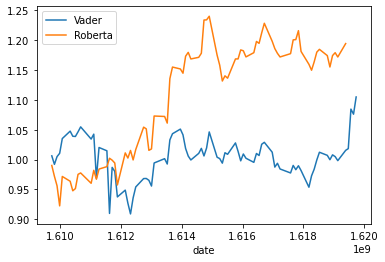

In [10]:
vader_factor_returns = al.performance.factor_returns(vader_data).iloc[:, 0]
roberta_factor_returns = al.performance.factor_returns(roberta_data).iloc[:, 0]
(1 + vader_factor_returns).cumprod().plot()
(1 + roberta_factor_returns).cumprod().plot()
plt.legend(["Vader", "Roberta"])

In [11]:
# qr_factor_returns = al.performance.mean_return_by_quantile(unix_factor_data)[0].iloc[:, 0]

# (10000*qr_factor_returns).plot.bar(
#     subplots=True,
#     sharey=True,
#     layout=(5,3),
#     figsize=(14, 14),
#     legend=False)

In [12]:
# ls_FRA = al.performance.factor_rank_autocorrelation(unix_factor_data)
# ls_FRA.plot(title="Factor Rank Autocorrelation")

In [13]:
# daily_annualization_factor = np.sqrt(252)

# (daily_annualization_factor * factor_returns.mean() / factor_returns.std()).round(2)